### HighIQ spectral processing example.

This notebook shows an example of how to process Doppler spectra from complex autocorrelation function (ACF) data. The example data in this notebook are from the Atmospheric Radiation Measurement program's Doppler Lidar in the Southern Great Plains site in Oklahoma. 

In [1]:
import highiq
import act
from datetime import datetime
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


This example shows how to process moments for a doppler lidar file from the ARM SGP site. The below example file is available at:
    
https://drive.google.com/uc?export=download&id=1x7pT4K05wJufepBR_26N1wpLzCoEEr9H

In [2]:
file_path = '/nfs/gce/projects/digr/sgp_lidar/sgpdlacfC1.a1.20170804.000113.nc.v0'

HighIQ uses xarray as its basic data model. Therefore, if you have ACF data in netCDF format, HighIQ will be able to load it without any preprocessing steps. The input dataset must contain 2 four dimensional arrays where the dimensions represent (time, number of samples, number of lags, and real/complex component) such as in the example dataset below.

In [3]:
my_ds = highiq.io.load_arm_netcdf(file_path)
my_ds

<xarray.Dataset>
Dimensions:      (complex: 2, nlags: 20, nsamples: 4000, time: 2184)
Coordinates:
  * nlags        (nlags) int16 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
  * complex      (complex) int16 1 2
  * time         (time) datetime64[ns] 2017-08-04T00:01:13.070000 ... 2017-08-04T00:59:59.900000
Dimensions without coordinates: nsamples
Data variables:
    base_time    (time) datetime64[ns] 2017-08-04 2017-08-04 ... 2017-08-04
    time_offset  (time) datetime64[ns] dask.array<chunksize=(2184,), meta=np.ndarray>
    azimuth      (time) float32 dask.array<chunksize=(2184,), meta=np.ndarray>
    elevation    (time) float32 dask.array<chunksize=(2184,), meta=np.ndarray>
    acf_bkg      (time, nsamples, nlags, complex) float32 dask.array<chunksize=(2184, 4000, 20, 2), meta=np.ndarray>
    acf          (time, nsamples, nlags, complex) float32 dask.array<chunksize=(2184, 4000, 20, 2), meta=np.ndarray>
    lat          (time) float32 36.6053 36.6053 36.6053 ... 36.6053 36.6053

The first step with this dataset is to process the doppler spectra from the ACF data. HighIQ makes this easy given you have an xarray dataset that has similar specifications to the dataset above. 

In [4]:
%time my_ds = highiq.calc.get_psd(my_ds)
my_ds

/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


CPU times: user 55.7 s, sys: 4.5 s, total: 1min
Wall time: 30.3 s


<xarray.Dataset>
Dimensions:                        (complex: 2, freq: 32, nlags: 20, nsamples: 4000, range: 400, time: 2184, vel_bin_interp: 256, vel_bins: 32)
Coordinates:
  * range                          (range) float64 0.0 30.0 ... 1.197e+04
  * time                           (time) datetime64[ns] 2017-08-04T00:01:13.070000 ... 2017-08-04T00:59:59.900000
  * vel_bin_interp                 (vel_bin_interp) float64 -19.35 ... 18.14
  * vel_bins                       (vel_bins) float64 -19.35 -18.14 ... 18.14
  * nlags                          (nlags) int16 0 1 2 3 4 5 ... 15 16 17 18 19
  * complex                        (complex) int16 1 2
Dimensions without coordinates: freq, nsamples
Data variables:
    base_time                      (time) datetime64[ns] 2017-08-04 ... 2017-08-04
    time_offset                    (time) datetime64[ns] dask.array<chunksize=(2184,), meta=np.ndarray>
    azimuth                        (time) float32 dask.array<chunksize=(2184,), meta=np.ndarray>


## Plotting power spectra

Power spectra then can be plotting using the standard .sel and .plot() commands that are built into xarray.
For example, if we want to pick out a certain range and time to plot the power spectra at, we can
simply use the below code.

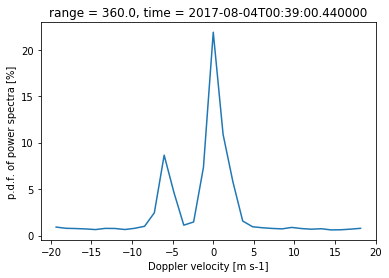

In [8]:
my_time = datetime.datetime(2017, 8, 4, 0, 39, 0)
my_ds["power_spectra_normed"].sel(time=my_time, range=350., method='nearest').plot()

Notice how the power spectra are not very smooth. This is because "power_spectra_normed" contains
the data points in the power spectra without any interpolation. We can use interpolation to create smoother
power spectra that provide greater numerical stability.

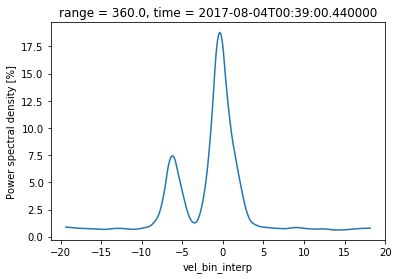

In [9]:
my_time = datetime.datetime(2017, 8, 4, 0, 39, 0)
my_ds["power_spectra_normed_interp"].sel(time=my_time, range=350., method='nearest').plot()
plt.savefig('bimodal_spectra.png', dpi=300)

The final step is to retrieve the lidar moments from the Doppler spectra. HighIQ makes this an easy step. All of the standard lidar moments (intensity, doppler velocity, spectral width, skewness, and kurtosis) can be retrieved using highiq.calc.get_lidar_moments. This must be done after the Doppler spectra are calculated.

In [12]:
my_ds = highiq.calc.get_lidar_moments(my_ds)
my_ds

<xarray.Dataset>
Dimensions:                        (complex: 2, freq: 32, nlags: 20, nsamples: 4000, range: 400, time: 2184, vel_bin_interp: 256, vel_bins: 32)
Coordinates:
  * range                          (range) float64 0.0 30.0 ... 1.197e+04
  * time                           (time) datetime64[ns] 2017-08-04T00:01:13.070000 ... 2017-08-04T00:59:59.900000
  * vel_bin_interp                 (vel_bin_interp) float64 -19.35 ... 18.14
  * vel_bins                       (vel_bins) float64 -19.35 -18.14 ... 18.14
  * nlags                          (nlags) int16 0 1 2 3 4 5 ... 15 16 17 18 19
  * complex                        (complex) int16 1 2
Dimensions without coordinates: freq, nsamples
Data variables:
    base_time                      (time) datetime64[ns] 2017-08-04 ... 2017-08-04
    time_offset                    (time) datetime64[ns] dask.array<chunksize=(2184,), meta=np.ndarray>
    azimuth                        (time) float32 dask.array<chunksize=(2184,), meta=np.ndarray>


Finally, we are able to plot our results. With just a few lines of code, HighIQ can leverage the existing plotting
routines in the Atmospheric Community Toolkit (ACT), available at https://anl-digr.github.io/ACT, in order to make high quality plots.

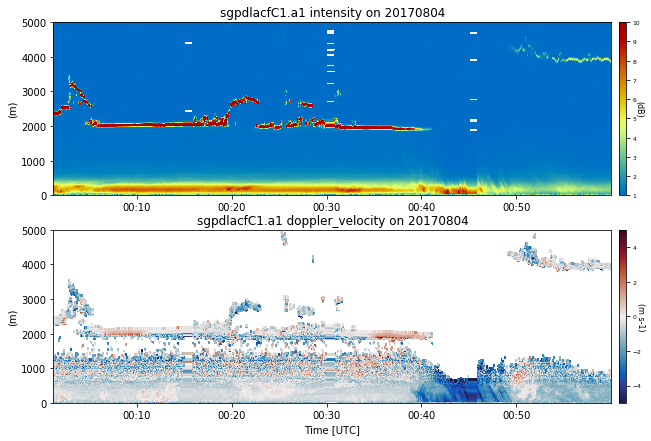

In [16]:
# Make a stricter mask for Doppler velocity to favor excluding more noise
my_ds['doppler_velocity'] = my_ds['doppler_velocity'].where(my_ds.intensity > 1.2)

# With ACT, we set up a TimeSeriesDisplay object with two sub plots
my_display = act.plotting.TimeSeriesDisplay(my_ds, figsize=(10,7), subplot_shape=(2,))

# The plot function takes in the same kwargs as matplotlib's plotting routines
my_display.plot('intensity', subplot_index=(0,), cmap='act_HomeyerRainbow', vmin=1, vmax=10)
my_display.plot('doppler_velocity', subplot_index=(1,), cmap='act_balance', vmin=-5, vmax=5)
my_display.set_yrng([0, 5000], subplot_index=(0,))
my_display.set_yrng([0, 5000], subplot_index=(1,))
my_display.fig.savefig('spectra_difference.png', dpi=300)